<a href="https://colab.research.google.com/github/snekumar/AD_cnn/blob/main/randomforestmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Importing TensorFlow and Keras modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    BatchNormalization, Concatenate, Conv2D, Dense, Dropout, Flatten,
    GaussianNoise, GlobalAveragePooling2D, Input, MaxPooling2D, Rescaling,
    Resizing, SeparableConv2D)
import tensorflow.keras.layers as layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Importing data processing and visualization modules
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Importing scikit-learn modules
from sklearn.metrics import confusion_matrix

# Importing miscellaneous modules
import random
import time

In [3]:
batch_size = 32
img_height = 220
img_width = 220
seed = 69

In [4]:
train_data = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Alzheimer_s Dataset/train",
    subset='training',
    validation_split=0.2,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 5125 files belonging to 4 classes.
Using 4100 files for training.


In [5]:
test_data = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Alzheimer_s Dataset/test",
    subset=None,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 1279 files belonging to 4 classes.


In [6]:
val_data = tf.keras.utils.image_dataset_from_directory(
     "/content/drive/MyDrive/Colab Notebooks/Alzheimer_s Dataset/train",
    subset='validation',
    validation_split=0.2,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 5125 files belonging to 4 classes.
Using 1025 files for validation.


In [7]:
class_names = train_data.class_names
num_classes = len(class_names)

print(f'{num_classes} classes: {class_names}')

4 classes: ['AD', 'CN', 'MCI', 'NonDemented']


In [8]:
AUTOTUNE = tf.data.AUTOTUNEAUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
def plot_images(n_rows=3, n_cols=7, data=train_data):
    plt.figure(figsize=(n_cols*2, int(n_rows*1.8)))
    for images, labels in data.take(int((n_rows * n_cols) / batch_size) + 1): # "take" takes random batch
        for i in range(n_rows*n_cols):
            ax = plt.subplot(n_rows, n_cols, i + 1)
            plt.imshow(images[i].numpy().astype("uint16"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

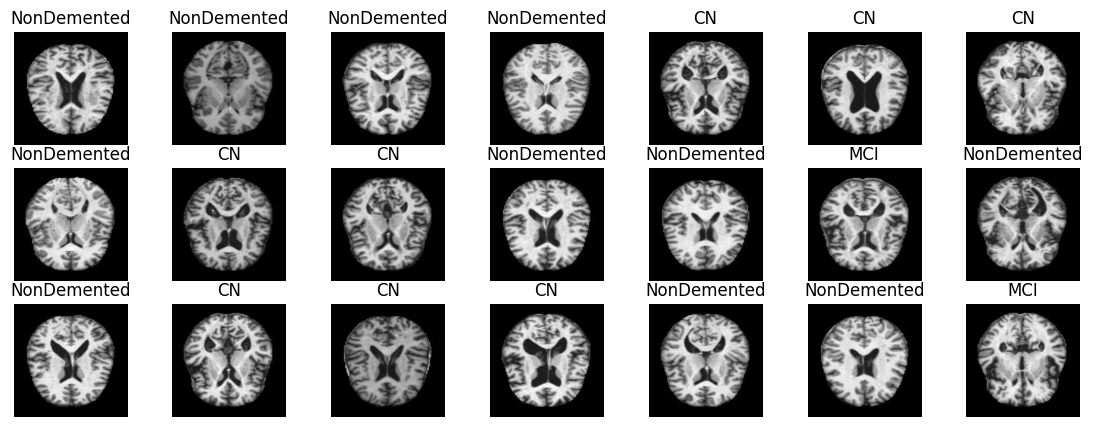

In [10]:
plot_images()

In [11]:
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Extract features from the training data
X_train_features = []
y_train_labels = []

for images, labels in train_data:
    preprocessed_images = preprocess_input(images)
    features = base_model.predict(preprocessed_images)
    flattened_features = features.reshape(features.shape[0], -1)
    X_train_features.append(flattened_features)
    y_train_labels.append(labels)

X_train_features = np.concatenate(X_train_features)
y_train_labels = np.concatenate(y_train_labels)

# Extract features from the test data
X_test_features = []
y_test_labels = []

for images, labels in test_data:
    preprocessed_images = preprocess_input(images)
    features = base_model.predict(preprocessed_images)
    flattened_features = features.reshape(features.shape[0], -1)
    X_test_features.append(flattened_features)
    y_test_labels.append(labels)

X_test_features = np.concatenate(X_test_features)
y_test_labels = np.concatenate(y_test_labels)


1/1 [==============================] - 19s 19s/step


In [12]:
# Extract features from the preprocessed images in val_data
X_val_features = []
y_val_labels = []
for images, labels in val_data:
    preprocessed_images = preprocess_input(images)
    features = base_model.predict(preprocessed_images)
    flattened_features = features.reshape(features.shape[0], -1)
    X_val_features.append(flattened_features)
    y_val_labels.append(labels)
X_val_features = np.concatenate(X_val_features)
y_val_labels = np.concatenate(y_val_labels)

1/1 [==============================] - 1s 850ms/step


In [15]:
# Specify the directory path in Google Drive
output_dir = '/content/drive/MyDrive/Colab Notebooks/featureext'

# Save X_train_features and y_train_labels
np.save(output_dir + 'X_train_features.npy', X_train_features)
np.save(output_dir + 'y_train_labels.npy', y_train_labels)
np.save(output_dir + 'X_val_features.npy', X_val_features)
np.save(output_dir + 'y_val_labels.npy', y_val_labels)


In [6]:

# Specify the directory path in Google Drive where the files are saved
input_dir = '/content/drive/MyDrive/Colab Notebooks/featureext'

# Load X_train_features
X_train_features = np.load(input_dir + 'X_train_features.npy')

# Load y_train_labels
y_train_labels = np.load(input_dir + 'y_train_labels.npy')

AUC Score (Class 0): 0.996912714005052
AUC Score (Class 1): 0.9464565513344121
AUC Score (Class 2): 0.9785373356801929
AUC Score (Class 3): 0.9480124773105141
Micro-average AUC Score: 0.9495693833035891


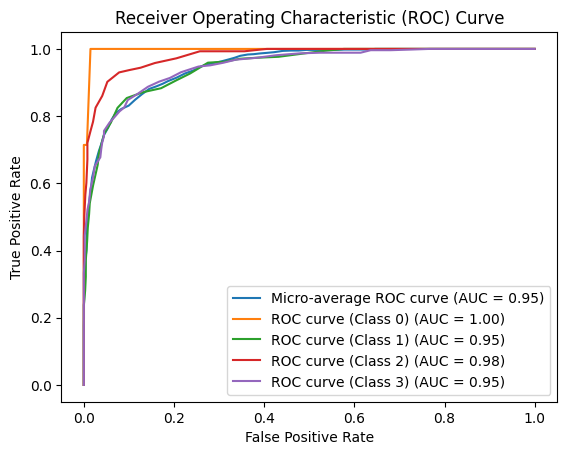

In [24]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the true labels
y_val_bin = label_binarize(y_val_labels, classes=np.unique(y_val_labels))

# Get the predicted probabilities for each class
y_val_pred_prob = rf_classifier.predict_proba(X_val_features)

# Compute the ROC curve and AUC score for each class
fpr = {}
tpr = {}
auc = {}
n_classes = y_val_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_val_pred_prob[:, i])
    auc[i] = roc_auc_score(y_val_bin[:, i], y_val_pred_prob[:, i])

# Compute micro-average ROC curve and AUC score
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_val_pred_prob.ravel())
auc["micro"] = roc_auc_score(y_val_bin, y_val_pred_prob, average="micro")

# Print the AUC scores for each class
for i in range(n_classes):
    print(f"AUC Score (Class {i}):", auc[i])

# Print the micro-average AUC score
print("Micro-average AUC Score:", auc["micro"])

# Plot the ROC curves for each class
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label="Micro-average ROC curve (AUC = {0:0.2f})".format(auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label="ROC curve (Class {0}) (AUC = {1:0.2f})".format(i, auc[i]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [25]:
from sklearn.metrics import accuracy_score, f1_score

# Calculate the accuracy
accuracy = accuracy_score(y_val_labels, y_val_pred)
print("Accuracy:", accuracy)

# Calculate the F-score
fscore = f1_score(y_val_labels, y_val_pred, average='macro')
print("F-score:", fscore)


Accuracy: 0.7873170731707317
F-score: 0.5158607209818457


In [28]:
import pickle
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Save the trained random forest model
with open('/content/drive/MyDrive/Colab Notebooks/featureext/random_forest_model.pickle', 'wb') as f:
    pickle.dump(rf_classifier, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import pickle

# Save the trained random forest model
with open('random_forest_model.pickle', 'wb') as f:
    pickle.dump(rf_classifier, f)


In [ ]:
pip install shap


In [ ]:
import shap

# Create an explainer object for the random forest model
explainer = shap.Explainer(rf_classifier, X_train_features)

# Compute Shapley values for a subset of data
shap_values = explainer.shap_values(X_train_features)

# Plot the summary plot to visualize feature importance
shap.summary_plot(shap_values, X_train_features, feature_names=X_train_features)


In [ ]:
import shap

# Extract the feature importance values from the random forest model
feature_importance_values = rf_classifier.feature_importances_

# Get the feature names
feature_names = X_train_features

# Create a SHAP explainer object
explainer = shap.Explainer(rf_classifier)

# Calculate SHAP values for the validation data
shap_values = explainer.shap_values(X_val_features)

# Plot the feature importance using SHAP
shap.summary_plot(shap_values, X_val_features, feature_names=feature_names, plot_type='bar')

# Visualize individual feature contributions using SHAP
sample_index = 0  # Choose an index from the validation data to explain
shap.force_plot(explainer.expected_value, shap_values[sample_index], X_val_features.iloc[sample_index], feature_names=feature_names)

# Plot dependence plots to explore feature interactions
shap.dependence_plot("age", shap_values, X_val_features, feature_names=feature_names)
shap.dependence_plot("education", shap_values, X_val_features, feature_names=feature_names)

# Explain an individual prediction using SHAP
prediction_index = 0  # Choose an index from the validation data to explain
shap.explain_instance(X_val_features.iloc[prediction_index], rf_classifier.predict_proba).plot()
